In [ ]:
! pip install matplotlib seaborn numpy scipy geopandas shapely xarray

In [7]:
import matplotlib.pyplot as plt
import HandleData as HandleData
import seaborn as sns
import numpy as np
from scipy.stats import gamma, norm
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import xarray as xr

In [ ]:


# Import functions from the climate_indices package
from climate_indices.compute import scale_values, Periodicity
from climate_indices import indices, compute, utils

# --- Step 1. Read CSV, Parse Dates, and Sort the Data ---
# Update the file path as needed.
# Here, we parse the 'data' column as datetime and sort by station (ion_name) and date.
df = pd.read_csv("your_station_data.csv", parse_dates=['data'])

# If needed, rename the station id column (if "ion_name" is actually station_id)
# df = df.rename(columns={'ion_name': 'station_id'})

# Sort the DataFrame by station and date so that the time series are in chronological order.
df = df.sort_values(by=['ion_name', 'data'])

# Verify the sorting (optional)
print(df.head())

# --- Step 2. Pivot the DataFrame to Create a Time Series for Each Station ---
# We pivot the data so that the index is the date and each column corresponds to a station's precipitation.
# In this example, we use the 'rrr24' column as precipitation.
df_pivot = df.pivot(index='data', columns='ion_name', values='rrr24')

# Convert the pivoted DataFrame to an xarray DataArray.
# The resulting DataArray 'da_precip' has dimensions: time x ion_name.
da_precip = df_pivot.to_xarray()['rrr24']

# --- Step 3. Define a Custom SPI Function ---
# This SPI function is adapted to work on a 1-D array (a time series) of precipitation values.
def spi(values, scale, distribution, data_start_year, calibration_year_initial, calibration_year_final, periodicity):
    # If values come as 2-D, flatten them; otherwise ensure they are 1-D.
    if values.ndim == 2:
        values = values.flatten()
    elif values.ndim != 1:
        raise ValueError(f"Invalid input shape {values.shape} – only 1-D or 2-D arrays are supported.")
    
    # If the series is entirely missing, return it as is.
    if np.all(np.isnan(values)):
        return values
    
    # Ensure no negative values are used.
    if np.amin(values) < 0:
        values = np.clip(values, a_min=0.0, a_max=None)
    
    original_length = values.size
    
    # Scale the time series using a sliding sum over 'scale' time steps.
    values = compute.sum_to_scale(values, scale)
    
    # Reshape into (years, months) for monthly data.
    if periodicity is compute.Periodicity.monthly:
        values = utils.reshape_to_2d(values, 12)
    elif periodicity is compute.Periodicity.daily:
        values = utils.reshape_to_2d(values, 366)
    else:
        raise ValueError("Invalid periodicity argument")
    
    # Fit the scaled data to a gamma distribution and transform to SPI values.
    if distribution is indices.Distribution.gamma:
        values = compute.transform_fitted_gamma(
            values, data_start_year, calibration_year_initial, calibration_year_final, periodicity
        )
    elif distribution is indices.Distribution.pearson:
        values = compute.transform_fitted_pearson(
            values, data_start_year, calibration_year_initial, calibration_year_final, periodicity
        )
    else:
        raise ValueError("Unsupported distribution argument")
    
    # Clip the SPI values to the valid range.
    fitted_min, fitted_max = -3.09, 3.09
    values = np.clip(values, fitted_min, fitted_max).flatten()
    
    return values[:original_length]

# --- Step 4. Set Up SPI Calculation Parameters ---
# Determine the data start year from the time coordinate.
initial_year = int(da_precip.time.dt.year.values[0])
scale_months = 3  # using a 3-month accumulation

# Adjust the calibration period as needed (here we use 1990–2010 as an example).
spi_args = {
    "scale": scale_months,
    "distribution": indices.Distribution.gamma,
    "data_start_year": initial_year,
    "calibration_year_initial": 1990,
    "calibration_year_final": 2010,
    "periodicity": compute.Periodicity.monthly,
}

# --- Step 5. Compute SPI for Each Station ---
# Apply the SPI function along the 'time' dimension for each station.
# We use vectorize=True so that the function is applied to each station's time series independently.
da_spi = xr.apply_ufunc(
    spi,
    da_precip,
    input_core_dims=[["time"]],
    kwargs=spi_args,
    vectorize=True,
    dask="parallelized"  # Remove or adjust if not using Dask
)

# --- Step 6. Plot the SPI for a Sample Station ---
# For example, plot SPI for station with ion_name 40708.
da_spi.sel(ion_name=40708).plot()
plt.title("SPI (3-Month Scale) for Station 40708")
plt.xlabel("Time")
plt.ylabel("SPI")
plt.show()


In [4]:

df = HandleData.get_data()
HandleData.show_data()
station_df = df[df['station_id'] == 40708]
january_df = station_df[station_df['date'].dt.month == [1,3,5,7,9]]
# january_df.head()
# # View the entire DataFrame
plt.figure(figsize=(12, 6))
plt.plot(january_df['date'], january_df['SPI'], label='SPI', color='blue')
plt.title('SPI Time Series')
plt.xlabel('Date')
plt.ylabel('SPI')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\varas\OneDrive\Documents\Codes\PredictionDroughtUsingLSTM-\Codes\HandleData.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['data'])


           station_name  station_id
0               Ardebil       40708
412            Khalkhal       40717
824            Parsabad       40700
1236            Mahabad       40726
1648               Maku       40701
2060           Orumiyeh       40712
2472               Ahar       40704
2884              Sarab       40710
3296             Mianeh       40716
3708  Maragheh-synoptic       40713
4120             Tabriz       40706
4532       Meshkinshahr       40705
4881  Ardebil (Airport)       88107


ValueError: ('Lengths must match to compare', (412,), (5,))

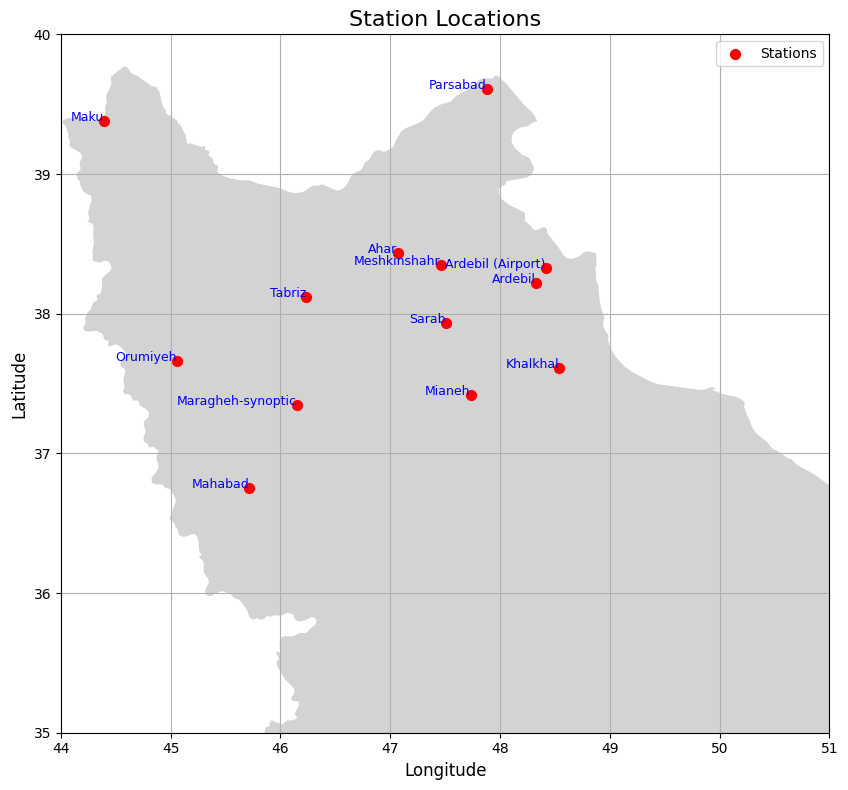

In [ ]:

world = gpd.read_file('ir_shp\ir.shp')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray')

# Extract unique station locations
stations = df[['station_name', 'lat', 'lon']].drop_duplicates()


# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]
geo_df = gpd.GeoDataFrame(stations, geometry=geometry)

# Set Coordinate Reference System (CRS) to WGS84 (EPSG:4326)
geo_df.set_crs(epsg=4326, inplace=True)

# Add station points
geo_df.plot(ax=ax, color='red', markersize=50, label='Stations')

# Add labels for station IDs
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station_name']):
    ax.text(x, y, str(label), fontsize=9, ha='right', color='blue')

xmin, xmax = 44, 51  # Adjust longitude range
ymin, ymax = 35, 40  # Adjust latitude range
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Customize the plot
plt.title('Station Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\Acer\AppData\Local\Temp\ipykernel_13432\110476579.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


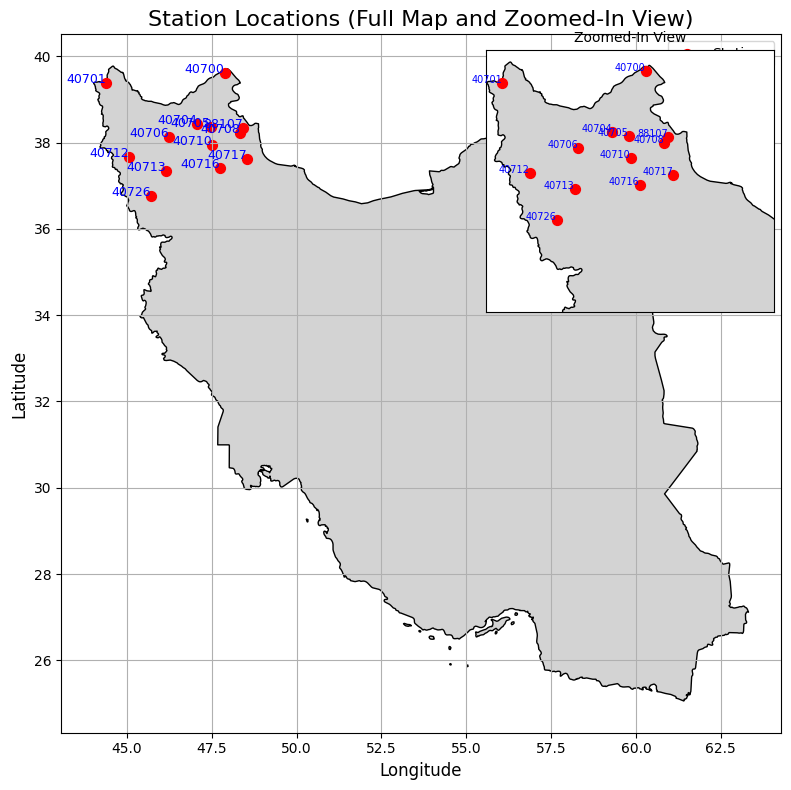

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Load Iran shapefile
world = gpd.read_file('ir_shp/ir.shp')


# Extract unique station locations
stations = df[['station_id', 'lat', 'lon']].drop_duplicates()

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]
geo_df = gpd.GeoDataFrame(stations, geometry=geometry)

# Set Coordinate Reference System (CRS) to WGS84 (EPSG:4326)
geo_df.set_crs(epsg=4326, inplace=True)

# Plot the full map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray', edgecolor='black')
geo_df.plot(ax=ax, color='red', markersize=50, label='Stations')

# Add labels for station IDs
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station_id']):
    ax.text(x, y, str(label), fontsize=9, ha='right', color='blue')

# Customize the main plot
plt.title('Station Locations (Full Map and Zoomed-In View)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid()

# Create an inset for the zoomed-in view
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')  # Adjust size and location
world.plot(ax=axins, color='lightgray', edgecolor='black')
geo_df.plot(ax=axins, color='red', markersize=50)

# Add labels in the inset
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station_id']):
    axins.text(x, y, str(label), fontsize=7, ha='right', color='blue')

# Set limits for the zoomed-in inset
xmin, xmax = 44, 51  # Adjust longitude range
ymin, ymax = 35, 40  # Adjust latitude range
axins.set_xlim(xmin, xmax)
axins.set_ylim(ymin, ymax)

# Remove gridlines and labels in the inset for a cleaner look
axins.set_xticks([])
axins.set_yticks([])
axins.set_title("Zoomed-In View", fontsize=10)

# Finalize and show the plot
plt.tight_layout()
plt.show()


# Define Functions
Define the functions used in the code.

In [2]:
def plot_spi(station_id, spi_df):
    """
    Plot the Standardized Precipitation Index (SPI) for a specific station.
    
    Parameters:
    station_id (int): The ID of the station to plot.
    spi_df (DataFrame): DataFrame containing SPI values.
    """
    station_data = spi_df[spi_df['station_id'] == station_id]
    plt.figure(figsize=(10, 6))
    plt.plot(station_data['data'], station_data['SPI'], marker='o', linestyle='-')
    plt.title(f'SPI for Station {station_id}')
    plt.xlabel('Date')
    plt.ylabel('SPI')
    plt.grid(True)
    plt.show()

    plot_spi(station_id=40708, spi_df=spi_df)

def plot_drought_heatmap(spi_df):
    """
    Plot a heatmap of drought conditions based on SPI values.
    
    Parameters:
    spi_df (DataFrame): DataFrame containing SPI values.
    """
    pivot_table = spi_df.pivot_table(index='data', columns='station_id', values='SPI')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='RdYlBu_r', center=0, annot=False, cbar_kws={'label': 'SPI'})
    plt.title('Drought Conditions Heatmap')
    plt.xlabel('Station ID')
    plt.ylabel('Month')
    plt.show()

    plot_drought_heatmap(spi_df)

In [3]:
# Group data by station and calculate SPI
def calculate_spi(precipitation, scale=1):
    """
    Calculate Standardized Precipitation Index (SPI)
    """
    rolling_precip = precipitation.rolling(window=scale).mean()
    mean = rolling_precip.mean()
    std = rolling_precip.std()
    z_scores = (rolling_precip - mean) / std
    spi = norm.cdf(z_scores) * 2 - 1
    return spi

# Calculate SPI for each station
stations = data['station_id'].unique()
spi_results = []
for station in stations:
    station_data = data[data['station_id'] == station].sort_values('data')
    station_data['SPI'] = calculate_spi(station_data['rrr24'])
    spi_results.append(station_data)

# Combine results
spi_df = pd.concat(spi_results)

# Save to a new CSV
spi_df.to_csv('Codes\spi_results.csv', index=False)


NameError: name 'data' is not defined

In [ ]:
# Standardized Precipitation Index (SPI)

    rolling_precip = precipitation.rolling(window=scale).mean()
    mean = rolling_precip.mean()
    std = rolling_precip.std()
    z_scores = (rolling_precip - mean) / std
    spi = norm.cdf(z_scores) * 2 - 1
    return spi

# Calculate SPI for each station
stations = data['station_id'].unique()
spi_results = []
for station in stations:
    station_data = data[data['station_id'] == station].sort_values('data')
    station_data['SPI'] = calculate_spi(station_data['rrr24'])
    spi_results.append(station_data)

# Combine results
spi_df = pd.concat(spi_results)

# Save to a new CSV
spi_df.to_csv('Codes\spi_results.csv', index=False)


In [10]:
def plot_spi_6_month_avg(station_id, spi_df):
    """
    Plot the 6-month moving average of the Standardized Precipitation Index (SPI) for a specific station.
    
    Parameters:
    station_id (int): The ID of the station to plot.
    spi_df (DataFrame): DataFrame containing SPI values with a 'date' column.
    """
    # Filter data for the given station
    station_data = spi_df[spi_df['station_id'] == station_id].copy()
    
    # Ensure the 'date' column is a datetime object for proper sorting
    station_data['data'] = pd.to_datetime(station_data['data'])
    station_data.sort_values('data', inplace=True)
    
    # Calculate the 6-month moving average for SPI
    station_data['SPI_6_month_avg'] = station_data['SPI'].rolling(window=6, min_periods=1).mean()
    
    # Plot the 6-month moving average SPI
    plt.figure(figsize=(10, 6))
    plt.plot(station_data['data'], station_data['SPI_6_month_avg'], marker='o', linestyle='-', label='6-Month Average')
    plt.title(f'6-Month Average SPI for Station {station_id}')
    plt.xlabel('Data')
    plt.ylabel('SPI')
    plt.grid(True)
    plt.legend()
    plt.show()

    plot_spi_6_month_avg(station_id=40708, spi_df= df)
